In [2]:
import pandas as pd
import numpy as np
import riskfolio as rp
import matplotlib.pyplot as plt
import pypfopt as ppo
import sqlite3
import os
import holidays

In [3]:
ibov_close = pd.read_csv(r'C:\Users\loren\Documents\Programação\Github\quantamental-Dev_Wizards\data\ativos_ibov\ivob_close.csv')

ibov_close.dropna(axis=1, thresh=len(ibov_close.index)/2, inplace=True)

ibov_close['Date'] = pd.to_datetime(ibov_close['Date'])
ibov_close.set_index('Date', inplace=True)
ibov_close = ibov_close.loc['2014-09-08':'2020-12-31']

returns = ibov_close.pct_change().iloc[1:]

In [4]:
ibov_close

,ABEV3.SA,ALPA4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,...,TAEE11.SA,TIMS3.SA,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-08,10.549572,7.253691,3.136998,8.532782,9.135706,9.192717,9.786984,2.477007,53.068676,9.669511,...,8.535804,9.005866,11.628489,3.993942,9.953420,6.350348,14.808646,21.484280,4.631629,20.229134
2014-09-09,10.509408,7.028021,3.046005,8.496013,9.138074,9.070141,9.635483,2.496511,52.576630,9.467273,...,8.411661,9.195751,11.474581,3.899661,9.953420,6.365933,15.077419,21.290218,4.563851,20.134260
2014-09-10,10.663368,6.937754,3.002783,8.362072,9.029059,8.845814,9.491556,2.483508,53.205360,9.441994,...,8.449279,9.236440,11.181020,4.032830,9.939199,6.155553,14.966749,21.167660,4.579988,19.900738
2014-09-11,10.576347,7.002232,3.020981,8.422477,9.031430,8.804188,9.665784,2.471806,53.141575,9.479913,...,8.618567,9.148280,11.400479,4.108255,9.997856,6.108803,14.945669,21.448528,4.609036,19.849653
2014-09-12,10.355448,6.866828,2.877667,8.217182,8.749419,8.556744,9.726384,2.464004,52.075470,9.543113,...,8.400376,9.283912,11.058465,4.109434,9.686810,6.233472,15.082690,21.244261,4.526731,19.295033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,13.411974,40.022732,16.984402,14.403756,15.741881,17.689098,8.638641,17.033195,21.151329,18.821211,...,23.868698,11.316670,26.411161,20.872667,9.502287,11.284576,58.565773,35.310223,34.237831,30.524500
2020-12-23,13.403327,40.645306,16.902689,14.640746,16.078325,18.093786,8.419428,17.093952,21.313152,18.959902,...,23.861460,11.450828,26.554392,21.069721,9.644721,11.809629,58.848698,35.388016,34.143803,31.197556
2020-12-28,13.636805,41.376587,17.328144,14.802502,16.214199,18.270027,8.354475,17.080744,21.370268,18.788580,...,24.353895,11.553421,26.859940,21.213724,9.726110,11.680384,58.815018,35.706974,35.497898,31.358711


In [5]:
# Portfolio simples com rp

port = rp.Portfolio(returns=returns)

method_mu = 'hist'    # Method to estimate expected returns based on historical data.
method_cov = 'hist'   # Method to estimate covariance matrix based on historical data.

# Estimate optimal portfolio:
model = 'Classic'     # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV'             # Risk measure used, this time will be variance
obj = 'Sharpe'        # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True           # Use historical scenarios for risk measures that depend on scenarios
rf = 0                # Risk free rate
l = 0                 # Risk aversion factor, only useful when obj is 'Utility'

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,ABEV3.SA,ALPA4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,...,TAEE11.SA,TIMS3.SA,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
weights,3.469999e-11,3.418495e-10,5.866908e-11,1.924653e-11,2.390810e-11,2.542263e-11,2.615414e-11,0.020919,1.578663e-11,3.271454e-11,...,4.810598e-10,3.002422e-11,4.740783e-11,0.219241,1.868294e-11,2.346506e-11,9.708812e-11,5.971261e-11,0.082628,2.857757e-11


In [6]:
N = returns.index
M = returns.columns
len(M)

61

In [7]:
def random_array():
    # Choose a random number of ones from a uniform distribution between 50 and 500
    num_ones = np.random.randint(50, 551)
    
    # Generate a binary array with the chosen number of ones placed randomly
    binary_array = np.zeros(len(N) - len(M))
    binary_array[:num_ones] = 1
    np.random.shuffle(binary_array) # Nx1 array
    binary_array = np.insert(binary_array, np.zeros(len(M), dtype=int), np.zeros(len(M), dtype=int)) # adiciona len(M) 0s no início do array
    
    return binary_array

In [8]:
def df_weights(returns, binary_array):
    weights_df = pd.DataFrame(columns=M) # 0xM matrix to store the weights 

    # Loop through each date and calculate the weights if the binary array value is 1
    for date in N[binary_array == 1]:

        port = rp.Portfolio(returns=returns)
        port.assets_stats(method_mu=method_mu, method_cov=method_cov)

        # Check if covariance matrix is positive definite
        cov_matrix = port.cov
        if not np.all(np.linalg.eigvals(cov_matrix) > 0):
            # Correct the covariance matrix to be positive definite
            cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6
            port.cov = cov_matrix

        weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
        weights_df.loc[date] = weights.T.values[0] # from 0xM to 150xM matrix - store the weights for the current date

    weights_df = weights_df.reindex(returns.index, method='ffill') # frontfill from 150xM to NxM matrix with NaN starting values

    # Fill the starting rows that have NaN values with equally distributed weights
    initial_weights = np.full(len(M), 1 / len(M))
    weights_df.iloc[:np.where(weights_df.notna().any(axis=1))[0][0]] = initial_weights
    weights_df.insert(0, 'rebalancing', binary_array)

    return weights_df

In [9]:
def random_rebalances_portfolio(returns, weights_df_random):
    portfolio_returns = (returns * weights_df_random.drop('rebalancing', axis=1)) # NxN vextor - calculate the portfolio returns

    normalized_portfolio_returns = (1 + portfolio_returns.sum(axis=1)).cumprod()
    
    return normalized_portfolio_returns

In [10]:
# teste para um porfólio
binary_array = random_array()
weights_df_random = df_weights(returns, binary_array)
normalized_portfolio_returns_random = random_rebalances_portfolio(returns, weights_df_random)

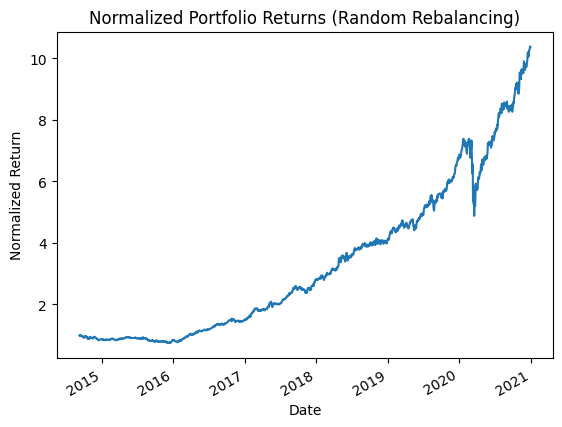

In [11]:
# Plot do um portfólio
normalized_portfolio_returns_random.plot(title='Normalized Portfolio Returns (Random Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

In [12]:
def simulate_portfolio():
    binary_array = random_array()
    weights_df_random = df_weights(returns, binary_array)
    normalized_portfolio_returns_random = random_rebalances_portfolio(returns, weights_df_random)
    
    cumulated_return = normalized_portfolio_returns_random.iloc[-1]
    return cumulated_return, binary_array, normalized_portfolio_returns_random

In [ ]:
from joblib import Parallel, delayed

num_simulations = 10
simulated_portfolios = []
binarray_cumret_dict = {}

# Paralelizando a simulação
results = Parallel(n_jobs=-1)(delayed(simulate_portfolio)() for _ in range(num_simulations))

# Separando os resultados
for cumulated_return, binary_array, normalized_portfolio_returns_random in results:
    simulated_portfolios.append(normalized_portfolio_returns_random)
    binarray_cumret_dict[cumulated_return] = binary_array

# Convertendo para DataFrame
simulated_portfolios_df = pd.DataFrame(simulated_portfolios).T

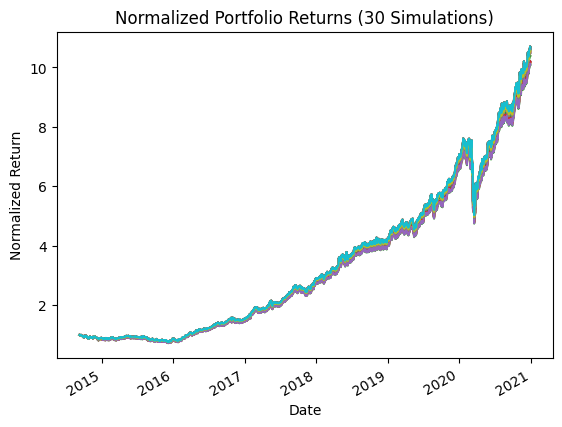

In [14]:
# Plot the results of the simulations
simulated_portfolios_df.plot(title=f'Normalized Portfolio Returns ({num_simulations} Simulations)', legend=False)
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

In [15]:
binarray_cumret_dict = dict(sorted(binarray_cumret_dict.items(), reverse=True))
binarray_cumret_dict

{10.686903687052988: array([0., 0., 0., ..., 0., 1., 0.]),
 10.615600284051032: array([0., 0., 0., ..., 1., 0., 0.]),
 10.558221372861874: array([0., 0., 0., ..., 0., 0., 0.]),
 10.518103996544099: array([0., 0., 0., ..., 0., 0., 1.]),
 10.486706059123783: array([0., 0., 0., ..., 0., 0., 0.]),
 10.485197982535011: array([0., 0., 0., ..., 1., 0., 0.]),
 10.392551442686461: array([0., 0., 0., ..., 0., 0., 0.]),
 10.195462470216304: array([0., 0., 0., ..., 1., 1., 0.]),
 10.17427062540764: array([0., 0., 0., ..., 0., 0., 0.]),
 10.141107073361045: array([0., 0., 0., ..., 0., 1., 1.]),
 10.110482665261594: array([0., 0., 0., ..., 1., 0., 0.]),
 10.08242814757098: array([0., 0., 0., ..., 0., 0., 0.])}

In [16]:
# Quantidade de rebalanceamentos dos melhores portfólios
quantity = 10
top_arrays = list(binarray_cumret_dict.values())[:quantity]
ones_count = [np.sum(array) for array in top_arrays]
print(ones_count)
print(np.mean(ones_count))

[342.0, 442.0, 409.0, 342.0, 139.0, 147.0, 124.0, 362.0, 128.0, 230.0]
266.5


In [17]:
# Conectar ao banco de dados SQLite (ou criar um novo)
conn = sqlite3.connect(r"C:\databases\simulations.db")

simulated_portfolios_df.to_sql('simulated_portfolios', conn, if_exists='append', index=False)

def load_simulations_from_db(conn):
    return pd.read_sql('SELECT * FROM simulated_portfolios', conn)

loaded_simulations_db = load_simulations_from_db(conn)

conn.close()

# Penalização
#### IMPORTANTE: a princípio, mais rebalanceamentos dão melhores resultados, mas o retorno real dos portfólios precisam considerar **custo de rebalanceamento** -- existe um viés de quantidade de rebalanceamentos que é diferente de obter apenas os >momentos< bons de reb. -- como eliminar ou diminuir esse viés? 

In [18]:
def penalized_portfolio(returns, weights_df_random, trans_cost_rate=0.01, tax_rate=0.2):
    penalized_returns = returns.copy()  # Copiar os retornos para aplicar penalizações
    accumulated_return = (1 + penalized_returns).cumprod()  # Retorno acumulado até o momento
    
    for i in range(1, len(weights_df_random)):  # Começa em 1 para poder comparar com a linha anterior
        current_weights = weights_df_random.iloc[i].drop('rebalancing')  # Pesos atuais
        previous_weights = weights_df_random.iloc[i - 1].drop('rebalancing')  # Pesos anteriores
        
        # Identificar as colunas (ações) onde o peso atual é menor que o peso anterior (vendas)
        reduced_weight_cols = current_weights.index[current_weights < previous_weights]
        
        for col in reduced_weight_cols:
            weight_diff = previous_weights[col] - current_weights[col]  # Diferença de pesos (parte vendida)
            
            # Aplicar custo de transação: proporcional ao valor vendido
            transaction_cost = trans_cost_rate * weight_diff * returns.iloc[i, returns.columns.get_loc(col)]
            
            # Aplicar imposto sobre ganhos de capital se houver lucro na venda
            if returns.iloc[i, returns.columns.get_loc(col)] > 0:  # Apenas se houve lucro
                capital_gain_tax = tax_rate * weight_diff * returns.iloc[i, returns.columns.get_loc(col)]
            else:
                capital_gain_tax = 0
            
            # Ajustar o retorno penalizado subtraindo os custos e impostos
            penalized_returns.iloc[i, returns.columns.get_loc(col)] -= (transaction_cost + capital_gain_tax)

    # Calcular os retornos do portfólio ajustado com penalizações
    portfolio_returns = (penalized_returns * weights_df_random.drop('rebalancing', axis=1))

    # Normalizar os retornos para obter o retorno acumulado
    normalized_portfolio_returns = (1 + portfolio_returns.sum(axis=1)).cumprod()

    return normalized_portfolio_returns

In [19]:
def simulate_penalized_portfolio():
    binary_array = random_array()
    weights_df_random = df_weights(returns, binary_array)
    normalized_portfolio_returns_random = penalized_portfolio(returns, weights_df_random)
    
    cumulated_return = normalized_portfolio_returns_random.iloc[-1]
    return cumulated_return, binary_array, normalized_portfolio_returns_random

In [20]:
# teste para um porfólio
binary_array = random_array()
weights_df_random = df_weights(returns, binary_array)
normalized_portfolio_returns_random = penalized_portfolio(returns, weights_df_random)

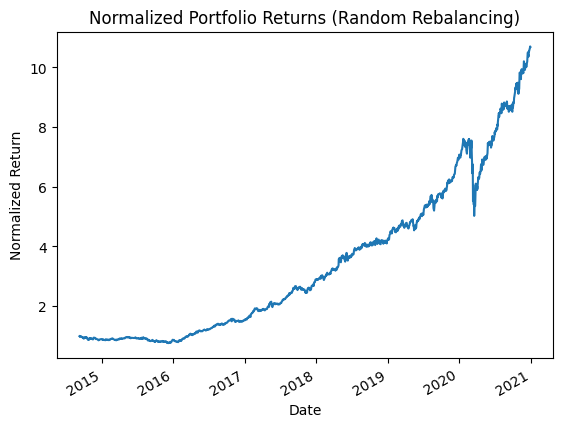

In [21]:
# Plot do um portfólio
normalized_portfolio_returns_random.plot(title='Normalized Portfolio Returns (Random Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

In [22]:
num_simulations = 10
simulated_portfolios = []
binarray_cumret_dict = {}

# Paralelizando a simulação
results = Parallel(n_jobs=-1)(delayed(simulate_penalized_portfolio)() for _ in range(num_simulations))

# Separando os resultados
for cumulated_return, binary_array, normalized_portfolio_returns_random in results:
    simulated_portfolios.append(normalized_portfolio_returns_random)
    binarray_cumret_dict[cumulated_return] = binary_array

# Convertendo para DataFrame
simulated_portfolios_df = pd.DataFrame(simulated_portfolios).T

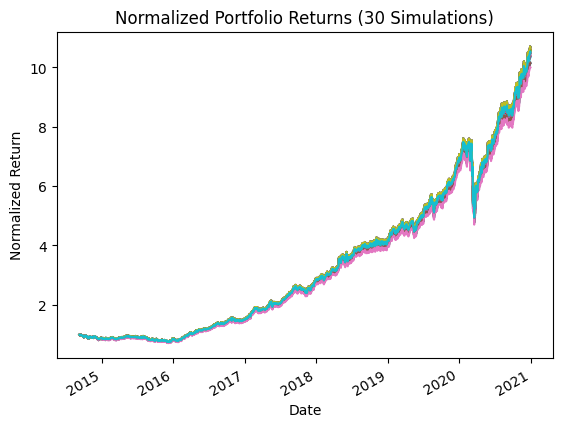

In [23]:
# Plot the results of the simulations
simulated_portfolios_df.plot(title=f'Normalized Portfolio Returns ({num_simulations} Simulations)', legend=False)
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

In [24]:
binarray_cumret_dict = dict(sorted(binarray_cumret_dict.items(), reverse=True))
binarray_cumret_dict

{10.686903368247517: array([0., 0., 0., ..., 0., 0., 0.]),
 10.615600301612316: array([0., 0., 0., ..., 0., 0., 0.]),
 10.558221417887287: array([0., 0., 0., ..., 0., 0., 0.]),
 10.518102387446744: array([0., 0., 0., ..., 0., 0., 0.]),
 10.486706143595217: array([0., 0., 0., ..., 1., 1., 0.]),
 10.485196129886202: array([0., 0., 0., ..., 0., 0., 0.]),
 10.474809492001512: array([0., 0., 0., ..., 0., 0., 0.]),
 10.433484448200671: array([0., 0., 0., ..., 0., 0., 0.]),
 10.392548810597528: array([0., 0., 0., ..., 1., 0., 0.]),
 10.372408585905847: array([0., 0., 0., ..., 0., 1., 0.]),
 10.334459977342819: array([0., 0., 0., ..., 0., 0., 0.]),
 10.163309857160733: array([0., 0., 0., ..., 1., 0., 1.]),
 10.141107143100637: array([0., 0., 0., ..., 0., 0., 0.]),
 10.131976954017654: array([0., 0., 0., ..., 0., 0., 0.]),
 9.998689949826712: array([0., 0., 0., ..., 0., 0., 0.])}

In [25]:
# Quantidade de rebalanceamentos dos melhores portfólios
quantity = 50
top_arrays = list(binarray_cumret_dict.values())[:quantity]
ones_count = [np.sum(array) for array in top_arrays]
print(ones_count)
print(np.mean(ones_count))

[205.0, 271.0, 223.0, 350.0, 420.0, 60.0, 184.0, 374.0, 76.0, 393.0, 212.0, 433.0, 296.0, 83.0, 155.0]
249.0


In [26]:
# Conectar ao banco de dados SQLite (ou criar um novo)
conn = sqlite3.connect(r"C:\databases\penalized_simulations.db")
simulated_portfolios_df.T.to_sql('simulated_portfolios', conn, if_exists='replace', index=False)

def load_simulations_from_db(conn):
    return pd.read_sql('SELECT * FROM simulated_portfolios', conn)

loaded_simulations_db = load_simulations_from_db(conn)

conn.close()